<a href="https://colab.research.google.com/github/MuhammadShavaiz/AI_learning/blob/main/Advanced_Query_Pipelines_over_Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question/Answer over TabularData**
This notebook demonstrates methods for performing question-answering tasks over tabular datasets. By leveraging structured data and appropriate tools, we aim to extract meaningful insights and provide accurate responses to queries.

In [39]:
!pip install llama-index==0.9.45.post1 arize-phoenix==2.2.1 pyvis

## **Importing Query Pipeline**

In [40]:
from llama_index.query_pipeline import (
    QueryPipeline as QP,
    Link,
    InputComponent,
)
from llama_index.query_engine.pandas import PandasInstructionParser
from llama_index.llms import OpenAI
from llama_index.prompts import PromptTemplate

## **Importing API**

In [41]:
import openai

openai.api_key = "key"


## **Download Data**
We first download the complete Databench dataset, a benchmark collection of datasets tailored for question-answering tasks over tabular data. Next, we evaluate specific datasets within the benchmark individually, assessing models performance and utility.


In [42]:
!pip install datasets

In [43]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset

# Load all QA pairs from the dataset
all_qa = load_dataset("cardiffnlp/databench", name="qa", split="train")

# Load the specific dataset (e.g., 001_Forbes)
ds_id = all_qa['dataset'][0]

# Load full dataset for "001_Forbes"
df = pd.read_parquet(f"hf://datasets/cardiffnlp/databench/data/{ds_id}/all.parquet")
# reading QA dataset
df2 = all_qa.to_pandas()


Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

## **Defining Modules**

### **The modules include:**
Pandas Prompt: Infers Pandas instructions from user queries.
Pandas Output Parser: Safely executes instructions on the dataframe and retrieves results.
Response Synthesis Prompt: Synthesizes final responses based on the dataframe.
LLM: Powers the overall processing pipeline.
The Pandas Output Parser ensures safe execution with strict module imports and avoids calling private methods.

In [44]:
# Instruction template for converting a natural language query to Pandas code
instruction_str = (
    "1. Convert the query to executable Python code using Pandas.\n"
    "2. The final line of code should be a Python expression that can be called with the `eval()` function.\n"
    "3. The code should represent a solution to the query.\n"
    "4. PRINT ONLY THE EXPRESSION.\n"
    "5. Do not quote the expression.\n"
)

# Template for constructing the prompt with Pandas dataframe information
pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`.\n"
    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "Query: {query_str}\n\n"
    "Expression:"
)

# Template for synthesizing a final response after executing Pandas instructions
response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output: {pandas_output}\n\n"
    "Response: "
)

# Preparing the Pandas prompt by partially formatting it with static details
pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df  # Providing instruction details and dataframe structure
)

# Parser to execute Pandas instructions and handle results
pandas_output_parser = PandasInstructionParser(df)

# Template to guide the response synthesis based on query and results
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)

# Using OpenAI's LLM for processing prompts
llm = OpenAI(model="gpt-3.5-turbo")


## **Build Query Pipeline**

Looks like this:
**input query_str -> pandas_prompt -> llm1 -> pandas_output_parser -> response_synthesis_prompt -> llm2**

Additional connections to response_synthesis_prompt: **llm1 -> pandas_instructions, and pandas_output_parser -> pandas_output.**

In [45]:
# Initialize the query pipeline (QP) with modules for processing
qp = QP(
    modules={
        "input": InputComponent(),  # Component to capture user input
        "pandas_prompt": pandas_prompt,  # Generates a Pandas-related prompt based on user query
        "llm1": llm,  # Language model to interpret the prompt and generate Pandas instructions
        "pandas_output_parser": pandas_output_parser,  # Executes Pandas instructions and processes results
        "response_synthesis_prompt": response_synthesis_prompt,  # Combines query, instructions, and output for a response
        "llm2": llm,  # Language model to synthesize the final response
    },
    verbose=True,  # Enable verbose mode for detailed logs during execution
)

# Define the processing chain for the pipeline
qp.add_chain([
    "input",  # Start with user input
    "pandas_prompt",  # Generate a Pandas-related prompt
    "llm1",  # Use the language model to create Pandas code
    "pandas_output_parser",  # Parse and execute Pandas instructions
])

# Add links to provide context between components
qp.add_links([
    # Link input directly to the response synthesis prompt with the query string
    Link("input", "response_synthesis_prompt", dest_key="query_str"),

    # Link the generated Pandas instructions to the response synthesis prompt
    Link("llm1", "response_synthesis_prompt", dest_key="pandas_instructions"),

    # Link the output of the Pandas parser to the response synthesis prompt
    Link("pandas_output_parser", "response_synthesis_prompt", dest_key="pandas_output"),
])

# Link the response synthesis prompt to the second LLM for generating the final response
qp.add_link("response_synthesis_prompt", "llm2")


## **Run Query**

In [46]:
df2['answer'].iloc[0]


'True'

In [47]:
response = qp.run(
    query_str=df2['question'].iloc[0],
)

> Running module input with input: 
query_str: Is the person with the highest net worth self-made?

> Running module pandas_prompt with input: 
query_str: Is the person with the highest net worth self-made?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
      rank                personName   age  finalWorth               cat...

> Running module pandas_output_parser with input: 
input: assistant: df.loc[df['finalWorth'].idxmax(), 'selfMade']

> Running module response_synthesis_prompt with input: 
query_str: Is the person with the highest net worth self-made?
pandas_instructions: assistant: df.loc[df['finalWorth'].idxmax(), 'selfMade']
pandas_output: True

> Running module llm2 with input: 
messages: Given an input question, synthesize a response from the query results.
Query: Is the person with the highest net worth self-made?

Pandas Instructions (optional):


In [48]:
print(response.message.content)

Yes, the person with the highest net worth is self-made.


# **Evaluation**
Rewriting some of the pipelines to get the desired output.

## **Forbes Dataset**

In [49]:
instruction_str = (
    "1. Convert the query to executable Python code using Pandas.\n"
    "2. The final line of code should be a Python expression that can be called with the `eval()` function.\n"
    "3. The code should represent a solution to the query.\n"
    "4. PRINT ONLY THE EXPRESSION.\n"
    "5. Do not quote the expression.\n"
)

pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`.\n"
    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "Query: {query_str}\n\n"
    "Expression:"
)
response_synthesis_prompt_str = (
    "return the answer after pandas query execution\n\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output: {pandas_output}\n\n"
)

pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df.head(5)
)
pandas_output_parser = PandasInstructionParser(df)
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)
llm = OpenAI(model="gpt-3.5-turbo")

In [50]:
qp = QP(
    modules={
        "input": InputComponent(),
        "pandas_prompt": pandas_prompt,
        "llm1": llm,
        "pandas_output_parser": pandas_output_parser,
        "response_synthesis_prompt": response_synthesis_prompt,
        "llm2": llm,
    },
    verbose=True,
)
qp.add_chain(["input", "pandas_prompt", "llm1", "pandas_output_parser"])
qp.add_links(
    [
        Link("input", "response_synthesis_prompt", dest_key="query_str"),
        Link(
            "llm1", "response_synthesis_prompt", dest_key="pandas_instructions"
        ),
        Link(
            "pandas_output_parser",
            "response_synthesis_prompt",
            dest_key="pandas_output",
        ),
    ]
)
# add link from response synthesis prompt to llm2
qp.add_link("response_synthesis_prompt", "llm2")

In [51]:
correct_answers = 0
for i in range(25):
  response = qp.run(
    query_str=df2['question'].iloc[i],
)
  ground_truth = df2['answer'].iloc[i]
  if(response.message.content == str(ground_truth)):
    correct_answers += 1

> Running module input with input: 
query_str: Is the person with the highest net worth self-made?

> Running module pandas_prompt with input: 
query_str: Is the person with the highest net worth self-made?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   rank                personName   age  finalWorth               catego...

> Running module pandas_output_parser with input: 
input: assistant: df.loc[df['finalWorth'].idxmax(), 'selfMade']

> Running module response_synthesis_prompt with input: 
query_str: Is the person with the highest net worth self-made?
pandas_instructions: assistant: df.loc[df['finalWorth'].idxmax(), 'selfMade']
pandas_output: True

> Running module llm2 with input: 
messages: return the answer after pandas query execution

Query: Is the person with the highest net worth self-made?

Pandas Instructions (optional):
df.loc[df['finalWorth']

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llama_index/query_engine/pandas/output_parser.py", line 54, in default_output_processor
    output_str = str(safe_eval(module_end_str, {"np": np}, local_vars))
  File "/usr/local/lib/python3.10/dist-packages/llama_index/exec_utils.py", line 139, in safe_eval
    _verify_source_safety(__source)
  File "/usr/local/lib/python3.10/dist-packages/llama_index/exec_utils.py", line 125, in _verify_source_safety
    if _contains_protected_access(__source):
  File "/usr/local/lib/python3.10/dist-packages/llama_index/exec_utils.py", line 110, in _contains_protected_access
    tree = ast.parse(code)
  File "/usr/lib/python3.10/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
TypeError: compile() arg 1 must be a string, bytes or AST object


> Running module input with input: 
query_str: Is the city with the most billionaires in the United States?

> Running module pandas_prompt with input: 
query_str: Is the city with the most billionaires in the United States?

> Running module llm1 with input: 
messages: You are working with a pandas dataframe in Python.
The name of the dataframe is `df`.
This is the result of `print(df.head())`:
   rank                personName   age  finalWorth               catego...

> Running module pandas_output_parser with input: 
input: assistant: df[df['country'] == 'United States']['city'].value_counts().idxmax()

> Running module response_synthesis_prompt with input: 
query_str: Is the city with the most billionaires in the United States?
pandas_instructions: assistant: df[df['country'] == 'United States']['city'].value_counts().idxmax()
pandas_output: New York

> Running module llm2 with input: 
messages: return the answer after pandas query execution

Query: Is the city with the most billi

### Accuracy

In [52]:
print("Accuracy for Forbes Dataset:")
Forbes_accuracy = (correct_answers/25)*100
print(Forbes_accuracy)

Accuracy for Forbes Dataset:
40.0


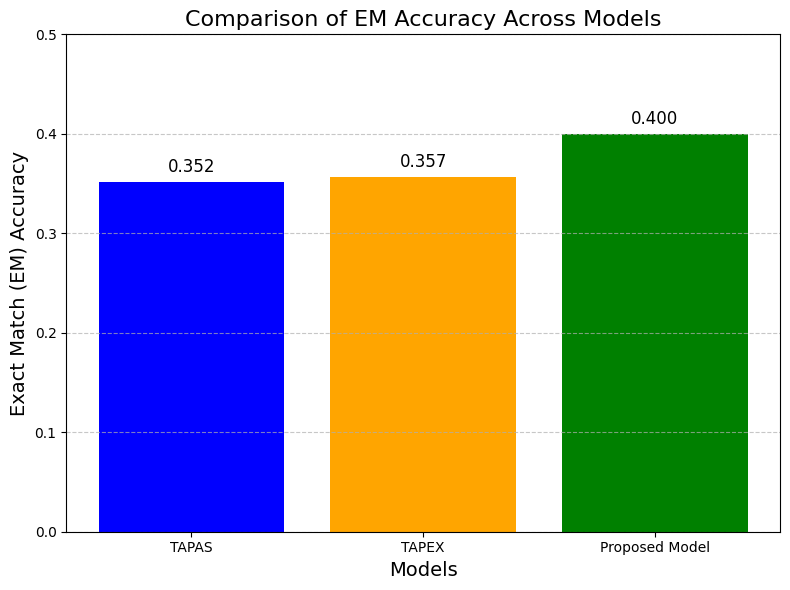

In [53]:
import matplotlib.pyplot as plt

# Data for the models and their EM accuracies
models = ['TAPAS', 'TAPEX', 'Proposed Model']
em_accuracies = [0.352, 0.357, 0.40]  # Hypothetical EM accuracy for Proposed Model

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, em_accuracies, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Exact Match (EM) Accuracy', fontsize=14)
plt.title('Comparison of EM Accuracy Across Models', fontsize=16)
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for i, v in enumerate(em_accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()
